# FE cz. 1
[Link do danych](https://www.kaggle.com/datasets/shubhamgoel27/dermnet)

About Dataset
Context
The data consists of images of 23 types of skin diseases taken from http://www.dermnet.com/dermatology-pictures-skin-disease-pictures. The total number of images are around 19,500, out of which approximately 15,500 have been split in the training set and the remaining in the test set.

Content
The images are in JPEG format, consisting of 3 channels, i.e. RGB. The resolutions vary from image to image, and from category to category, but overall these are not extremely high resolution imagery.

The categories include acne, melanoma, Eczema, Seborrheic Keratoses, Tinea Ringworm, Bullous disease, Poison Ivy, Psoriasis, Vascular Tumors, etc.

Acknowledgements
The images are taken from the public portal Dermnet (http://www.dermnet.com/) which is the largest dermatology source online built for the purpose of providing online medical education.

## Loading libraries

In [81]:
import os
import cv2
import random
import imageio
import zipfile
import numpy as np
import collections
import pandas as pd
import seaborn as sns
from PIL import Image, ImageOps
from functools import partial
import SimpleITK as sitk
import scipy.ndimage as ndi
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import distance
from skimage import io, measure, morphology, data, exposure
from skimage.feature import canny, graycomatrix, graycoprops
from skimage.color import rgb2gray, label2rgb
from skimage.filters import gaussian, threshold_otsu, try_all_threshold
from skimage.segmentation import slic
from skimage.util import random_noise
from skimage.restoration import denoise_tv_chambolle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Input
from tensorflow.keras.datasets import cifar10
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AgglomerativeClustering, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter("ignore")

# pip list --format=freeze > requirements.txt

## Step-by-step procedure CNN
### Loading the dataset

In [156]:
# Define the path to the directory containing subdirectories with images
dataset_path = '../Data/train'
files_per_directory = 10
img_size = 32

# Initialize an empty list to store the images
images = []

# Traverse the directory structure
for root, dirs, files in os.walk(dataset_path):
    
    limit = files_per_directory
    
    for file in files:
        if file.endswith('.jpg'):
            # Construct the full path to the image
            file_path = os.path.join(root, file)
            
            # Open the image
            img = Image.open(file_path)
            
            # Resize the image to 32x32 pixels
            img = img.resize((img_size, img_size))
            
            # Convert the image to a numpy array and normalize the pixel values
            img_array = np.array(img) / 255.0
            
            # Add the image array to the list
            images.append(img_array)
            
            # Adding a limit to images per directory
            limit -= 1
            if limit == 0:
                break

# Convert the list of images to a numpy array
images_array = np.array(images)

print(f"Shape of the images array: {images_array.shape}")

Shape of the images array: (230, 32, 32, 3)


### Building an autoencoder

In [157]:
# Define the autoencoder model
input_img = Input(shape=(img_size, img_size, 3))  # Adjust shape based on your images

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(images_array, images_array,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6932 - val_loss: 0.6857
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.6851 - val_loss: 0.6901
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.6860 - val_loss: 0.6841
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.6809 - val_loss: 0.6832
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.6810 - val_loss: 0.6808
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.6793 - val_loss: 0.6775
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.6762 - val_loss: 0.6745
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.6726 - val_loss: 0.6695
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.6684 - val_loss: 0.6615
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.6621 - val_loss: 0.6544
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.6560 - val_loss: 0.6532
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.6598 - val_loss:

### Extracting features

In [158]:
# Create encoder model
encoder = Model(input_img, encoded)

# Extract features
features = encoder.predict(images_array)
features = features.reshape((features.shape[0], -1))  # Flatten the features for clustering
features_original = features.copy()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


### Dimensionality reduction

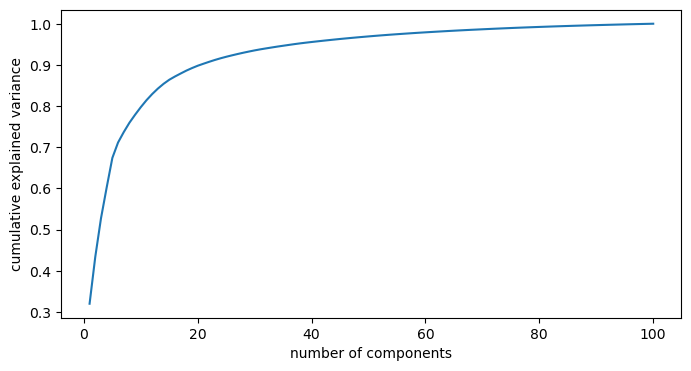

In [159]:
def reduce_dimensions_pca(pca_components, features, do_plot=False):

    features = PCA(n_components=pca_components).fit_transform(features_original)

    pca = PCA().fit(features)

    if do_plot:
        plt.figure(figsize=(8,  4))
        plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('cumulative explained variance');
    
    return features

features = reduce_dimensions_pca(100, features, True)
# features = features_original

### Evaluating the Clusters

In [94]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def count_wcss_scores(X, k, model):
    #  WCSS = within-cluster sum of squares
    kmeans = model(n_clusters=k, random_state=0)
    kmeans.fit(X)
    return kmeans.score(X) * -1 # score returns -WCSS

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

def create_data_frame(max_parameter, features):

    # Initialize an empty DataFrame
    df = pd.DataFrame()

    # Example data to add row by row
    algorithms = {
        'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
        'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
        'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
        'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
        'Kmeans': KMeans,
        'KMedoids': KMedoids
    }
    metrics = {
        'min dist between clusters': min_interclust_dist,
        'mean dist in clust': mean_inclust_dist,
        'std dev dist in clust': std_dev_of_inclust_dist,
        'mean dist to clust center': mean_dist_to_center,
        'silhouette': silhouette_score,
    }

    index = 0
    # Add rows to the DataFrame in a for loop
    for i, algorithm in enumerate(algorithms):
        print('{0: <33}'.format(f'{algorithm}')+'[-', end='')
        for cluster_num in range(2, max_parameter+1):
            print(f'{cluster_num}-', end='')
            df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
            df.loc[index, 'Feature_len'] = len(features[0])
            df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
            model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
    #         df.loc[index, 'WCSS'] = count_wcss_scores(features, cluster_num, algorithms[algorithm])
            index += 1
        print(']')
        
    return df
   
df = create_data_frame(5, features)
df.head()

Agglomerative ward linkage       [-2-3-4-5-]
Agglomerative complete linkage   [-2-3-4-5-]
Agglomerative average linkage    [-2-3-4-5-]
Agglomerative single linkage     [-2-3-4-5-]
Kmeans                           [-2-3-4-5-]
KMedoids                         [-2-3-4-5-]


Algorithm  Parameters  Feature_len  \
0      Agglomerative ward linkage         2.0        100.0   
1      Agglomerative ward linkage         3.0        100.0   
2      Agglomerative ward linkage         4.0        100.0   
3      Agglomerative ward linkage         5.0        100.0   
4  Agglomerative complete linkage         2.0        100.0   

   min dist between clusters  mean dist in clust  std dev dist in clust  \
0                   0.947471            2.652446               0.320311   
1                   0.947471            2.622165               0.368970   
2                   0.771552            2.409644               0.447753   
3                   0.771552            2.458160               0.388043   
4                   0.855910            2.623520               0.127278   

   mean dist to clust center  silhouette  
0                   1.850608    0.141766  
1                   1.827967    0.141501  
2                   1.673158    0.112067  
3                   1.700708    0.127256  
4                   1.824817    0.145271

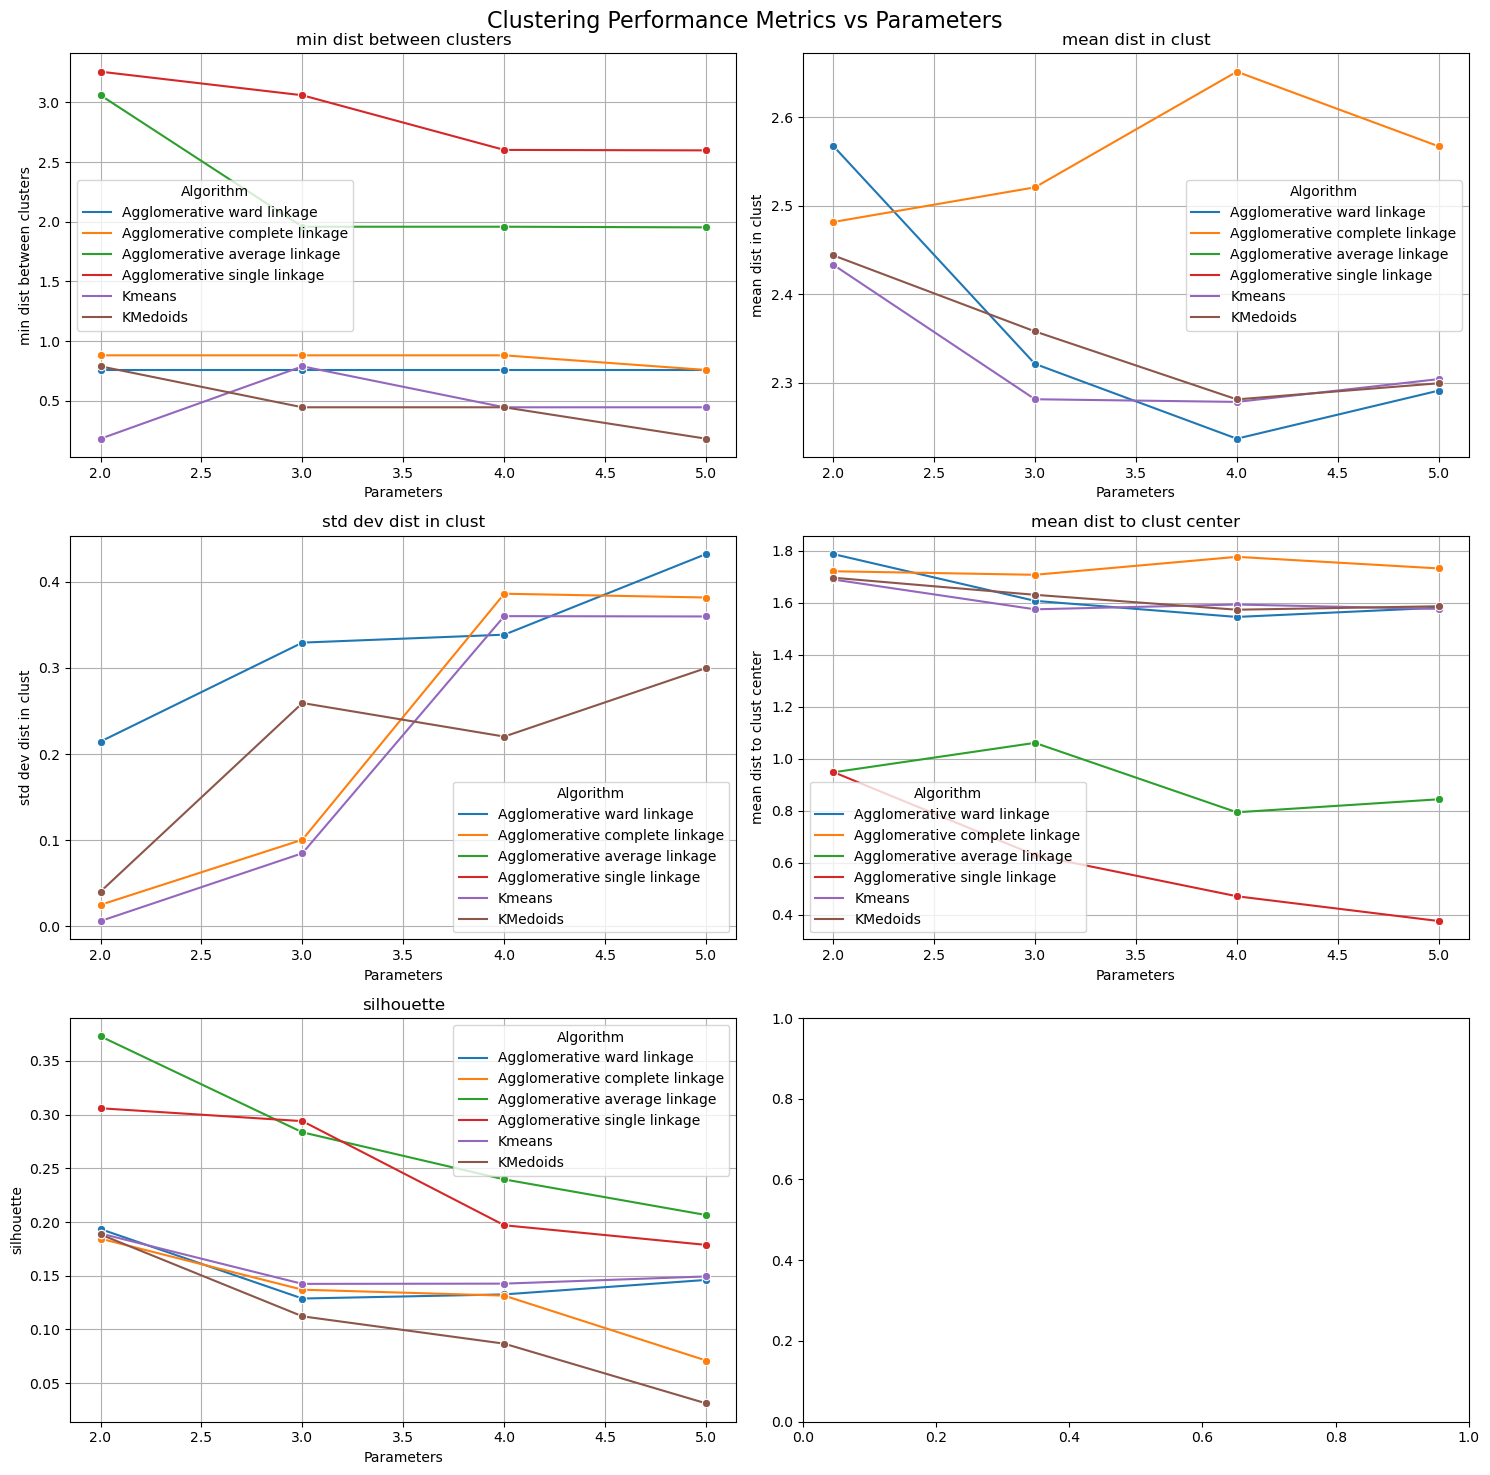

In [7]:
def plot_df(df):
    # List of metrics to plot
    metrics_vals = [
        'min dist between clusters',
        'mean dist in clust',
        'std dev dist in clust',
        'mean dist to clust center',
        'silhouette',
    #     'WCSS'
    ]

    # Set up the subplot grid (3 rows, 2 columns)
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    # Iterate over metrics and create a plot for each
    for i, metric in enumerate(metrics_vals):
        sns.lineplot(data=df, x='Parameters', y=metric, hue='Algorithm', marker='o', ax=axes[i])
        axes[i].set_title(f'{metric}')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Parameters')
        axes[i].legend(title='Algorithm')
        axes[i].grid(True)
    fig.suptitle('Clustering Performance Metrics vs Parameters', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
plot_df(df)

### Applying K-means Clustering

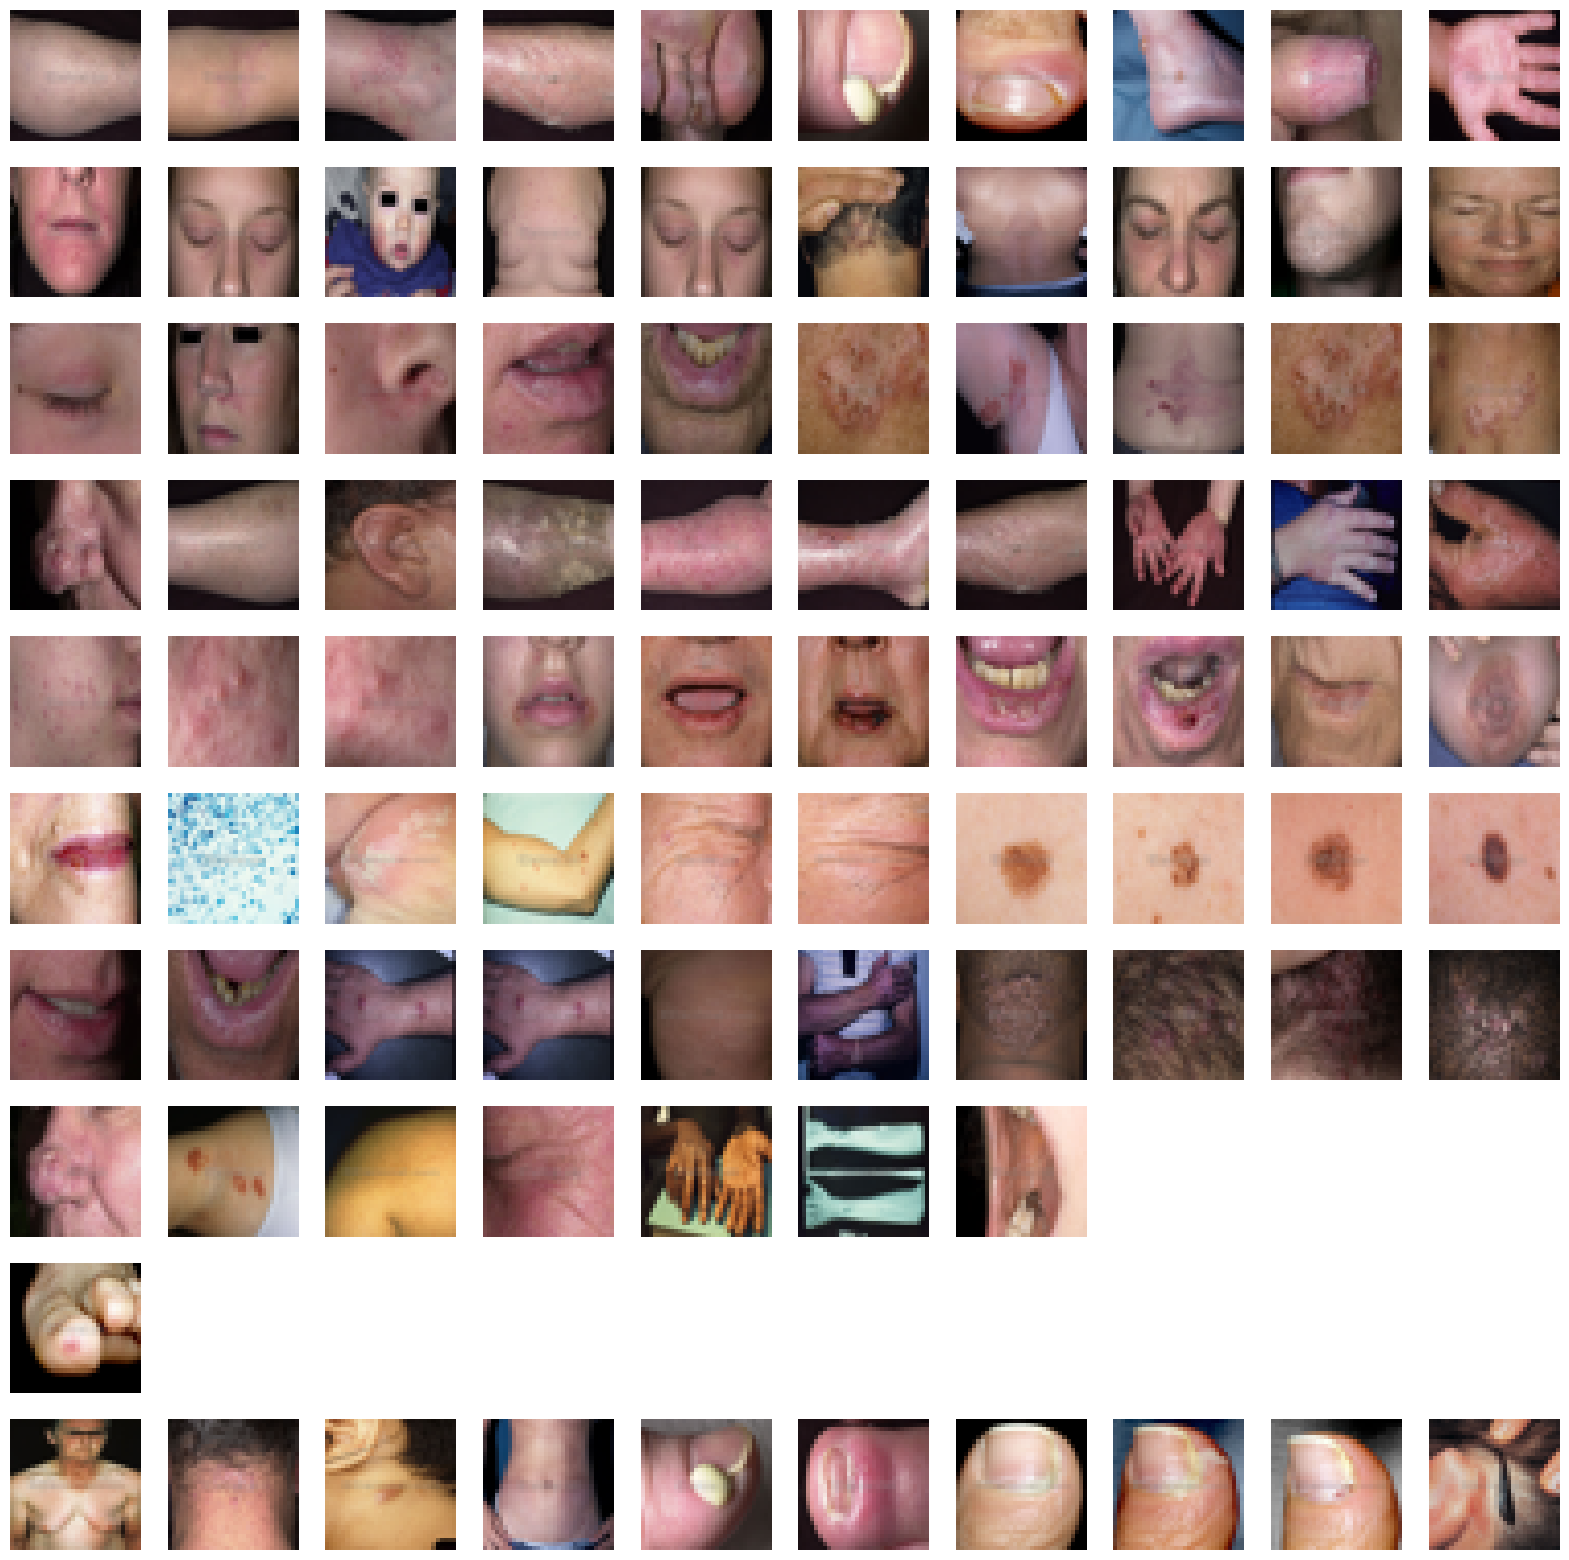

In [8]:
# Define the number of clusters
num_clusters = 10  # Choose an appropriate number of clusters

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

def plot_clusters(images, labels, num_clusters):
    plt.figure(figsize=(20, 20))
    for cluster in range(num_clusters):
        cluster_images = images[labels == cluster]
        for i in range(min(len(cluster_images), 10)):
            plt.subplot(num_clusters, 10, cluster * 10 + i + 1)
            plt.imshow(cluster_images[i])
            plt.axis('off')
    plt.show()

plot_clusters(images_array, clusters, num_clusters)

## Normalizing brightness and adding zero-padding

In [100]:
def add_padding_to_make_square(img):
    """
    Add padding to an image to make it square.
    """
    width, height = img.size
    if width == height:
        return img
    else:
        max_side = max(width, height)
        new_img = ImageOps.expand(img, (
            (max_side - width) // 2, 
            (max_side - height) // 2, 
            (max_side - width + 1) // 2, 
            (max_side - height + 1) // 2
        ), fill=(0, 0, 0))
        return new_img

def adjust_brightness(img, target_brightness):
    """
    Adjust the brightness of an image to match the target brightness.
    """
    grayscale_img = img.convert('L')
    img_array = np.array(grayscale_img)
    
    current_brightness = np.mean(img_array)
    brightness_factor = target_brightness / current_brightness
    
    img_array = np.array(img, dtype=np.float32)
    img_array = img_array * brightness_factor
    
    img_array = np.clip(img_array, 0, 255).astype(np.uint8)
    
    return Image.fromarray(img_array)

def normalize_images_brightness(images, target_brightness=None):
    """
    Normalize the brightness of all images to match the target brightness.
    """
    if target_brightness is None:
        total_brightness = 0
        for img in images:
            grayscale_img = img.convert('L')
            img_array = np.array(grayscale_img)
            total_brightness += np.mean(img_array)
        target_brightness = total_brightness / len(images)
    
    normalized_images = [adjust_brightness(img, target_brightness) for img in images]
    
    return normalized_images

# Load images from directory and pad them to be square, then resize to 32x32
data_dir = '../Data/train'
img_size = 32
images = []
for root, dirs, files in os.walk(data_dir):
    for file in files[:500]:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            img = Image.open(file_path)
            img = add_padding_to_make_square(img)
            img = img.resize((img_size, img_size))
            images.append(img)

# Normalize the brightness of all images
normalized_images = normalize_images_brightness(images)

# Convert normalized images to numpy array
images_array = np.array([np.array(img) / 255.0 for img in normalized_images])

print(f"Shape of the images array: {images_array.shape}")

Shape of the images array: (9957, 32, 32, 3)


In [101]:
# Define the autoencoder model
input_img = Input(shape=(img_size, img_size, 3))  # Adjust shape based on your images

# Feature layers to plot later
layers = []

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
layers.append(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
layers.append(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
layers.append(encoded)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
layers.append(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
layers.append(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
layers.append(decoded)

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(images_array, images_array,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

# Create encoder model
encoder = Model(input_img, encoded)

# Extract features
features = encoder.predict(images_array)
features = features.reshape((features.shape[0], -1))  # Flatten the features for clustering
features_original = features.copy()

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.5744 - val_loss: 0.4347
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 0.4242 - val_loss: 0.4216
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 0.4150 - val_loss: 0.4161
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 0.4089 - val_loss: 0.4127
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - loss: 0.4079 - val_loss: 0.4128
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - loss: 0.4077 - val_loss: 0.4101
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - loss: 0.4049 - val_loss: 0.4088
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - loss: 0.4036 - val_loss: 0.4081
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 0.4023 - val_loss: 0.4077
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 0.4027 - val_loss: 0.4065
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - loss: 0.4012 - val_loss: 0.4065
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


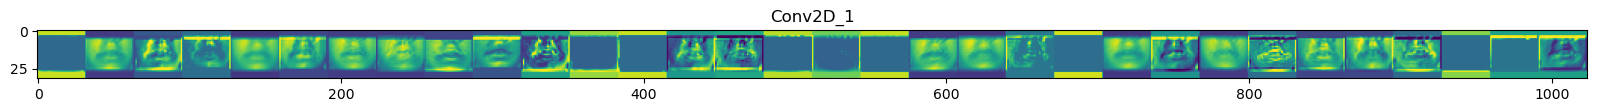

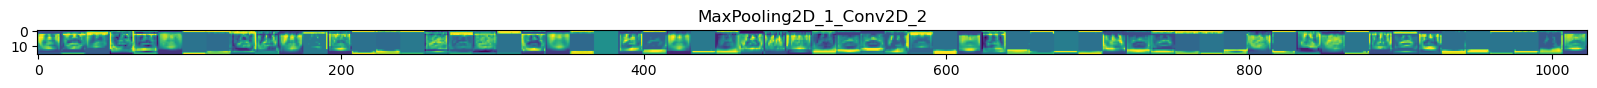

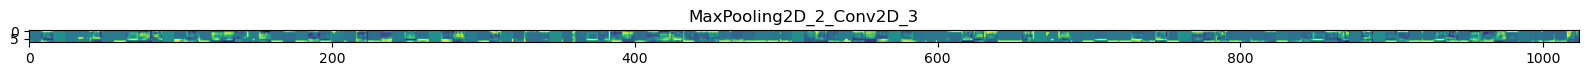

In [102]:
# Create intermediate layer model
layer_outputs = layers
feature_model = Model(inputs=autoencoder.input, outputs=layer_outputs)

# Get the feature maps
sample_image = images_array[7]  # Use the first image as a sample
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension
feature_maps = feature_model.predict(sample_image)

# Plot the feature maps
def plot_feature_maps(feature_maps, layer_names):
    num_layers = len(feature_maps)
    for layer_idx, feature_map in enumerate(feature_maps):
        num_filters = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * num_filters))
        for i in range(num_filters):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        scale = 20. / num_filters
        plt.figure(figsize=(scale * num_filters, scale))
        plt.title(layer_names[layer_idx])
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
def plot_all_images(images, columns=10):
    """
    Plot all images in the given array.

    Parameters:
    - images: Array of images (numpy arrays).
    - title: Title for the plot (default: "Images").
    - columns: Number of columns in the plot grid (default: 5).
    """
    num_images = len(images)
    rows = (num_images // columns) + 1
    
    plt.figure(figsize=(15, num_images/10))
    
    for i in range(num_images):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    
    plt.show()

layer_names = ['Conv2D_1', 'MaxPooling2D_1_Conv2D_2', 'MaxPooling2D_2_Conv2D_3',
               'Conv2D_1', 'UpSampling2D_1_Conv2D_2', 'UpSampling2D_2_Conv2D_3']
plot_feature_maps(feature_maps[:-3], layer_names[:-3])

### Clustering
#### Dimensionality reduction with PCA

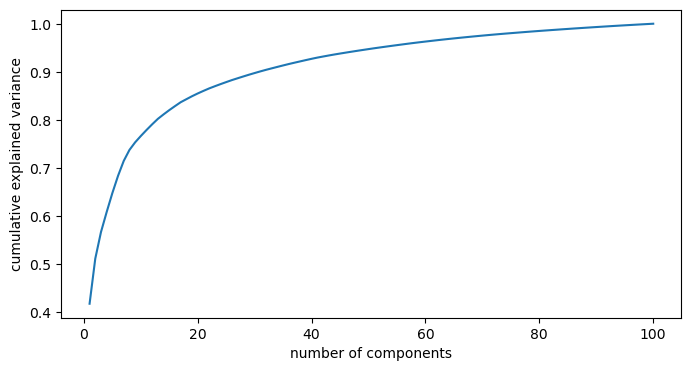

In [21]:
features = reduce_dimensions_pca(100, features, True)
# features = features_original

#### Evaluating clusters

In [22]:
df = create_data_frame(20, features)
df

Agglomerative ward linkage       [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]
Agglomerative complete linkage   [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]
Agglomerative average linkage    [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]
Agglomerative single linkage     [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]
Kmeans                           [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]
KMedoids                         [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]


Algorithm  Parameters  Feature_len  \
0    Agglomerative ward linkage         2.0        100.0   
1    Agglomerative ward linkage         3.0        100.0   
2    Agglomerative ward linkage         4.0        100.0   
3    Agglomerative ward linkage         5.0        100.0   
4    Agglomerative ward linkage         6.0        100.0   
..                          ...         ...          ...   
109                    KMedoids        16.0        100.0   
110                    KMedoids        17.0        100.0   
111                    KMedoids        18.0        100.0   
112                    KMedoids        19.0        100.0   
113                    KMedoids        20.0        100.0   

     min dist between clusters  mean dist in clust  std dev dist in clust  \
0                     2.685989            6.986302               0.216522   
1                     1.755807            6.946217               1.481956   
2                     1.755807            6.461496               1.589047   
3                     1.755807            6.633554               1.430314   
4                     1.755807            6.745234               1.448391   
..                         ...                 ...                    ...   
109                   0.260351            5.374196               1.571718   
110                   0.225060            5.350519               1.582493   
111                   0.225060            5.309753               1.548716   
112                   0.225060            5.224696               1.669634   
113                   0.306057            5.256020               1.561451   

     mean dist to clust center  silhouette  
0                     4.865033    0.418070  
1                     4.858993    0.246135  
2                     4.528643    0.228542  
3                     4.645580    0.233926  
4                     4.723876    0.220112  
..                         ...         ...  
109                   3.741120    0.037970  
110                   3.725673    0.032045  
111                   3.695733    0.027342  
112                   3.638137    0.030380  
113                   3.659053    0.029718  

[114 rows x 8 columns]

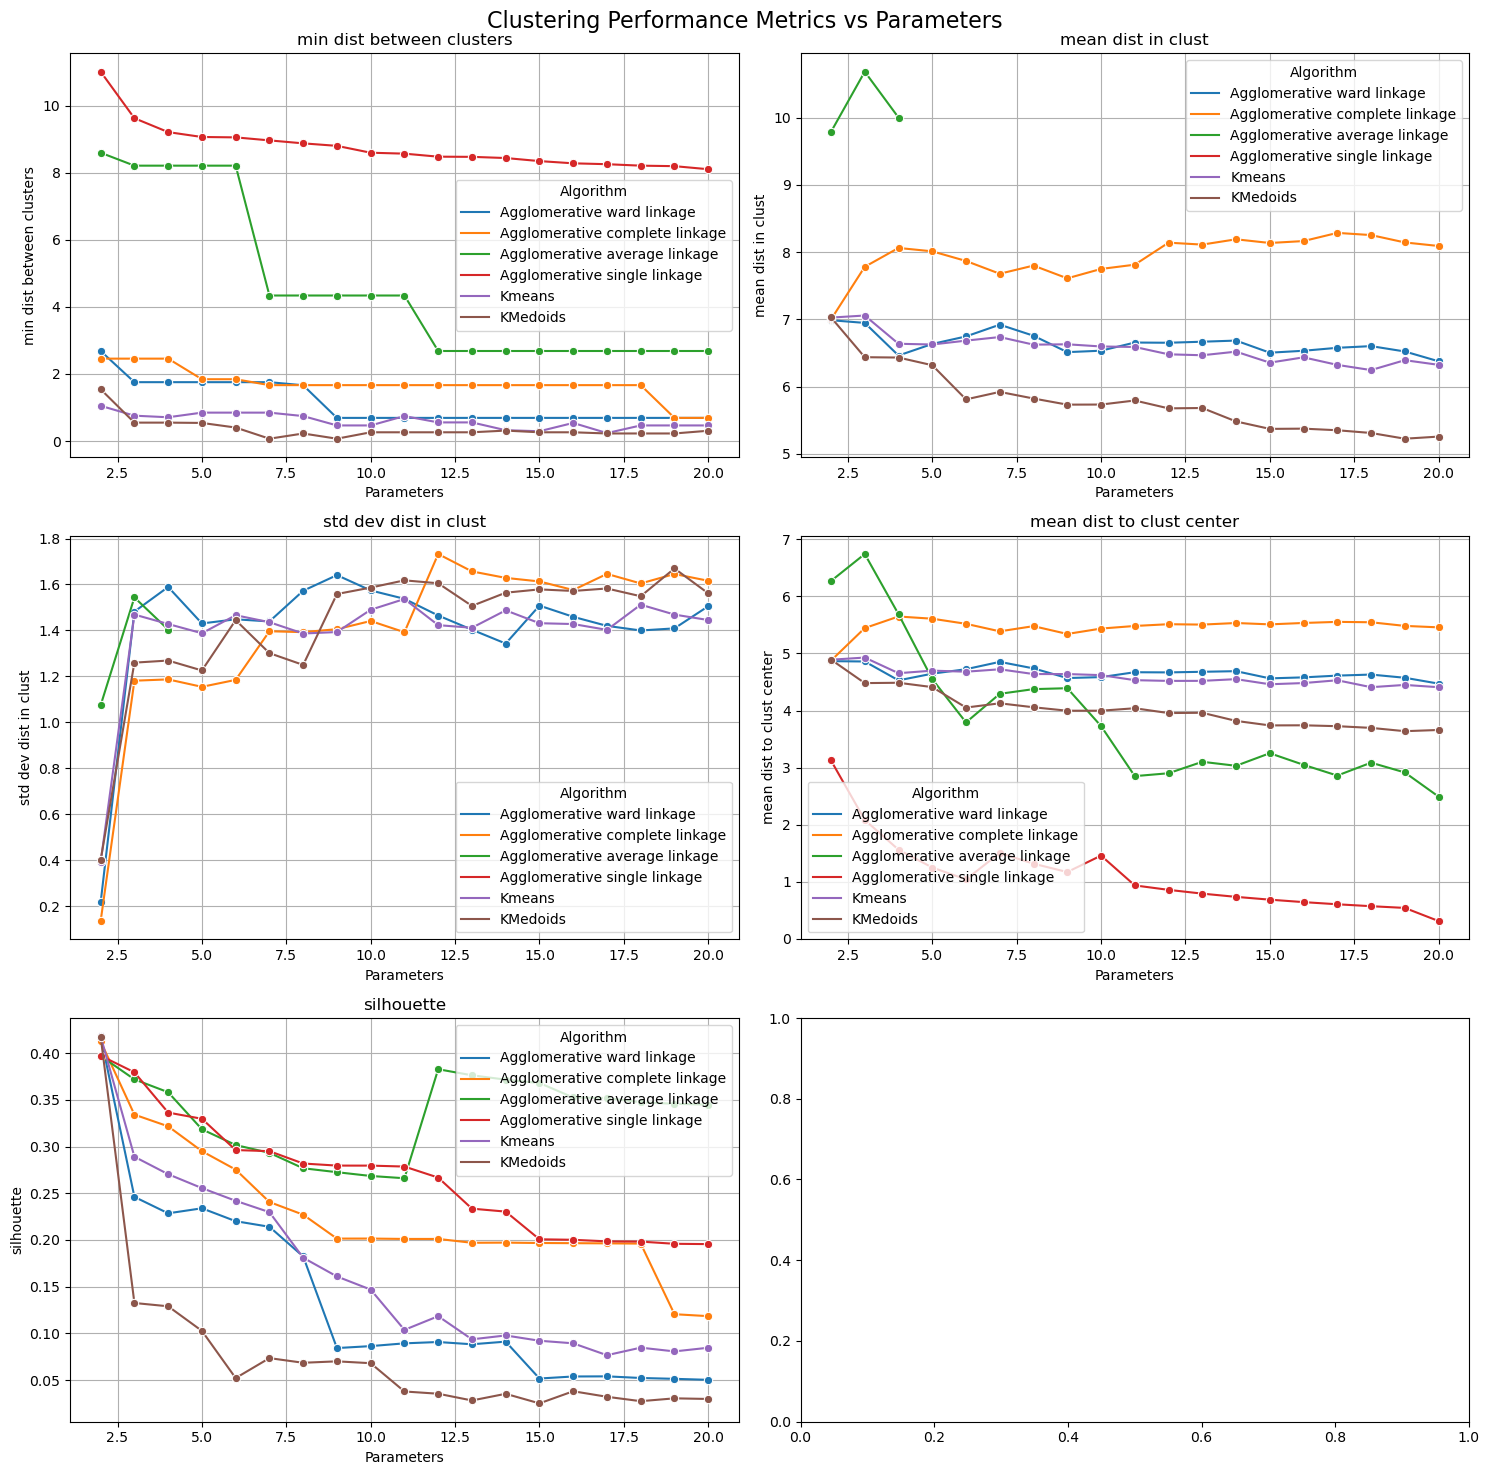

In [23]:
plot_df(df)

#### Showcasing clustering results
##### Agglomerative ward linkage ward

In [24]:
# Define the number of clusters
num_clusters = 20

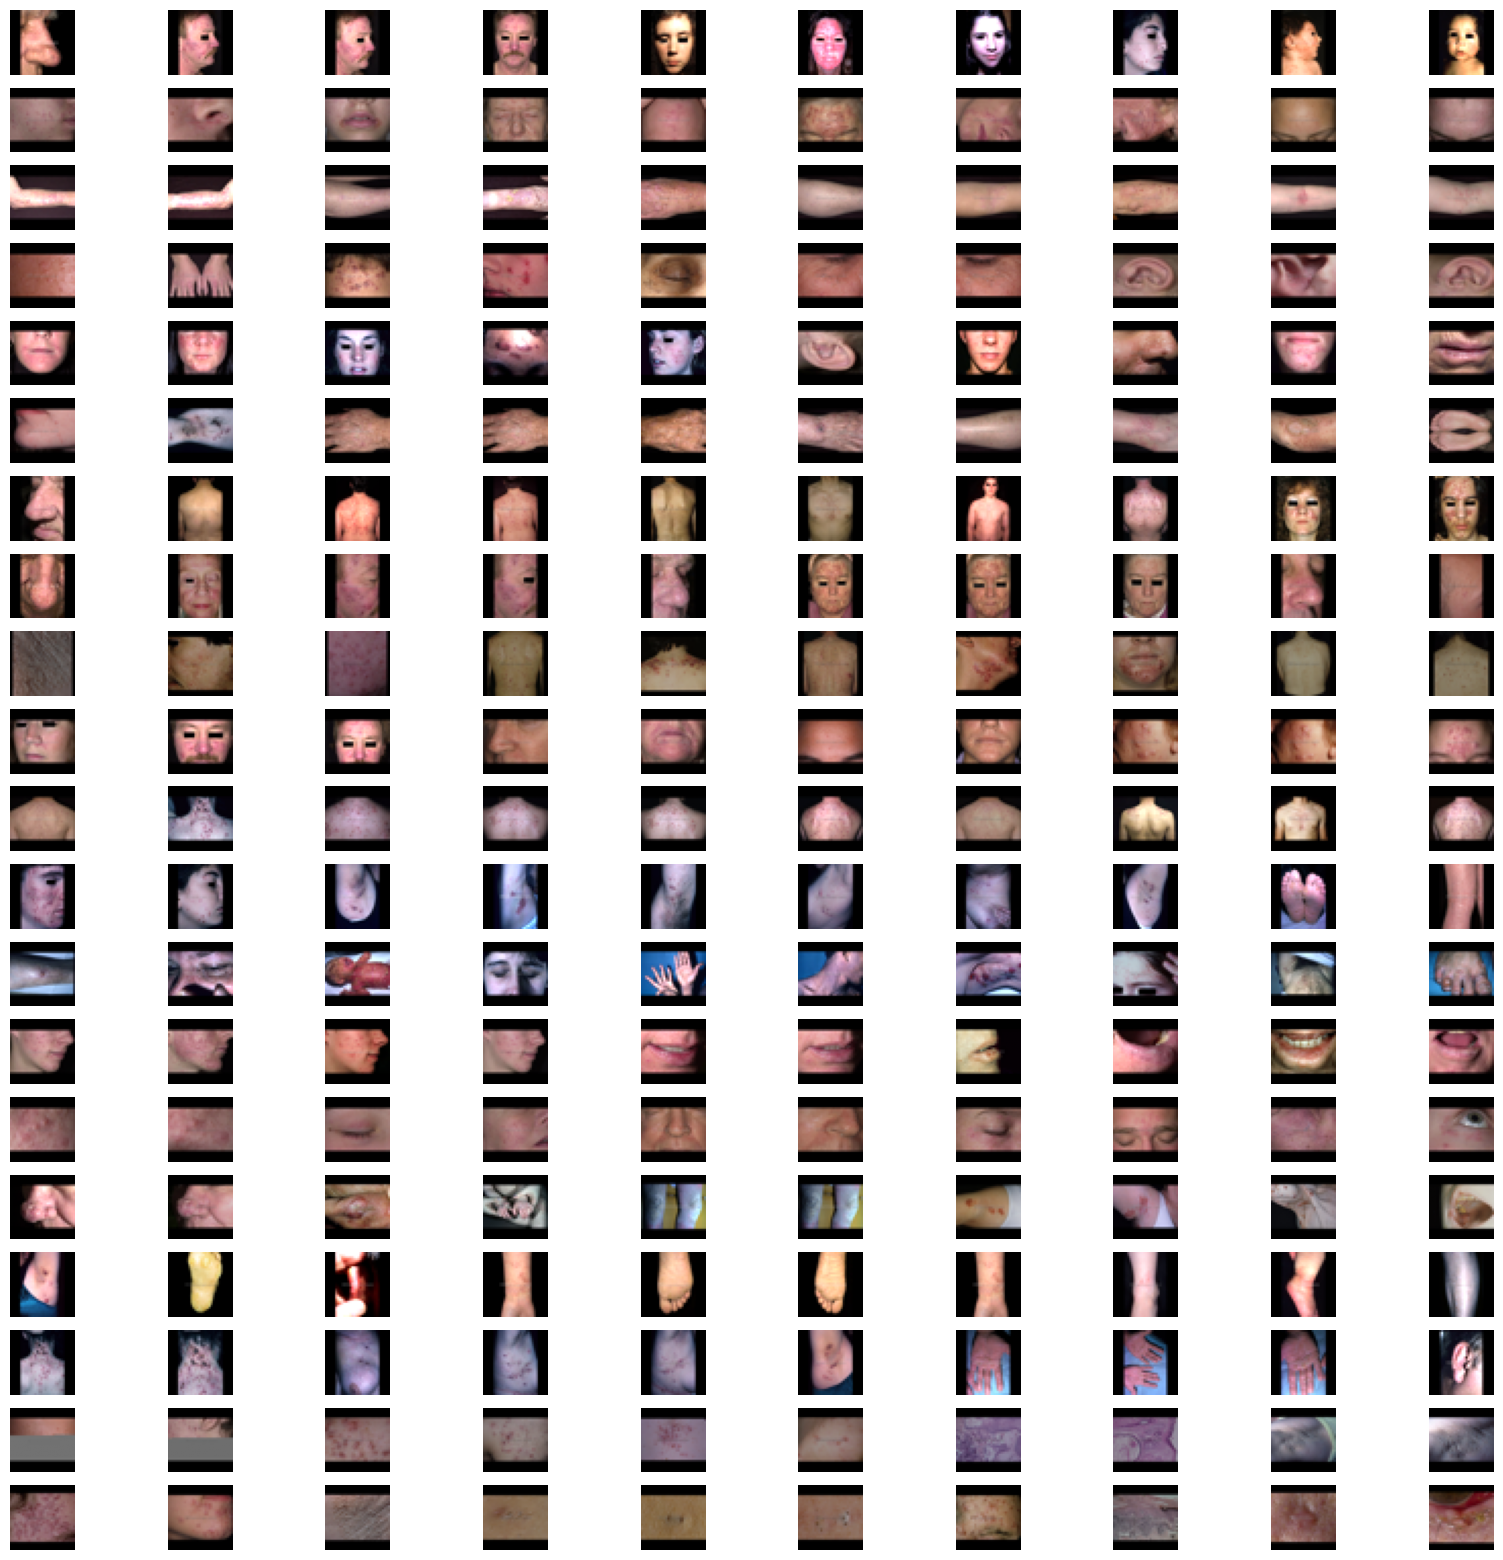

In [25]:
clusters = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward').fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### Agglomerative ward linkage complete

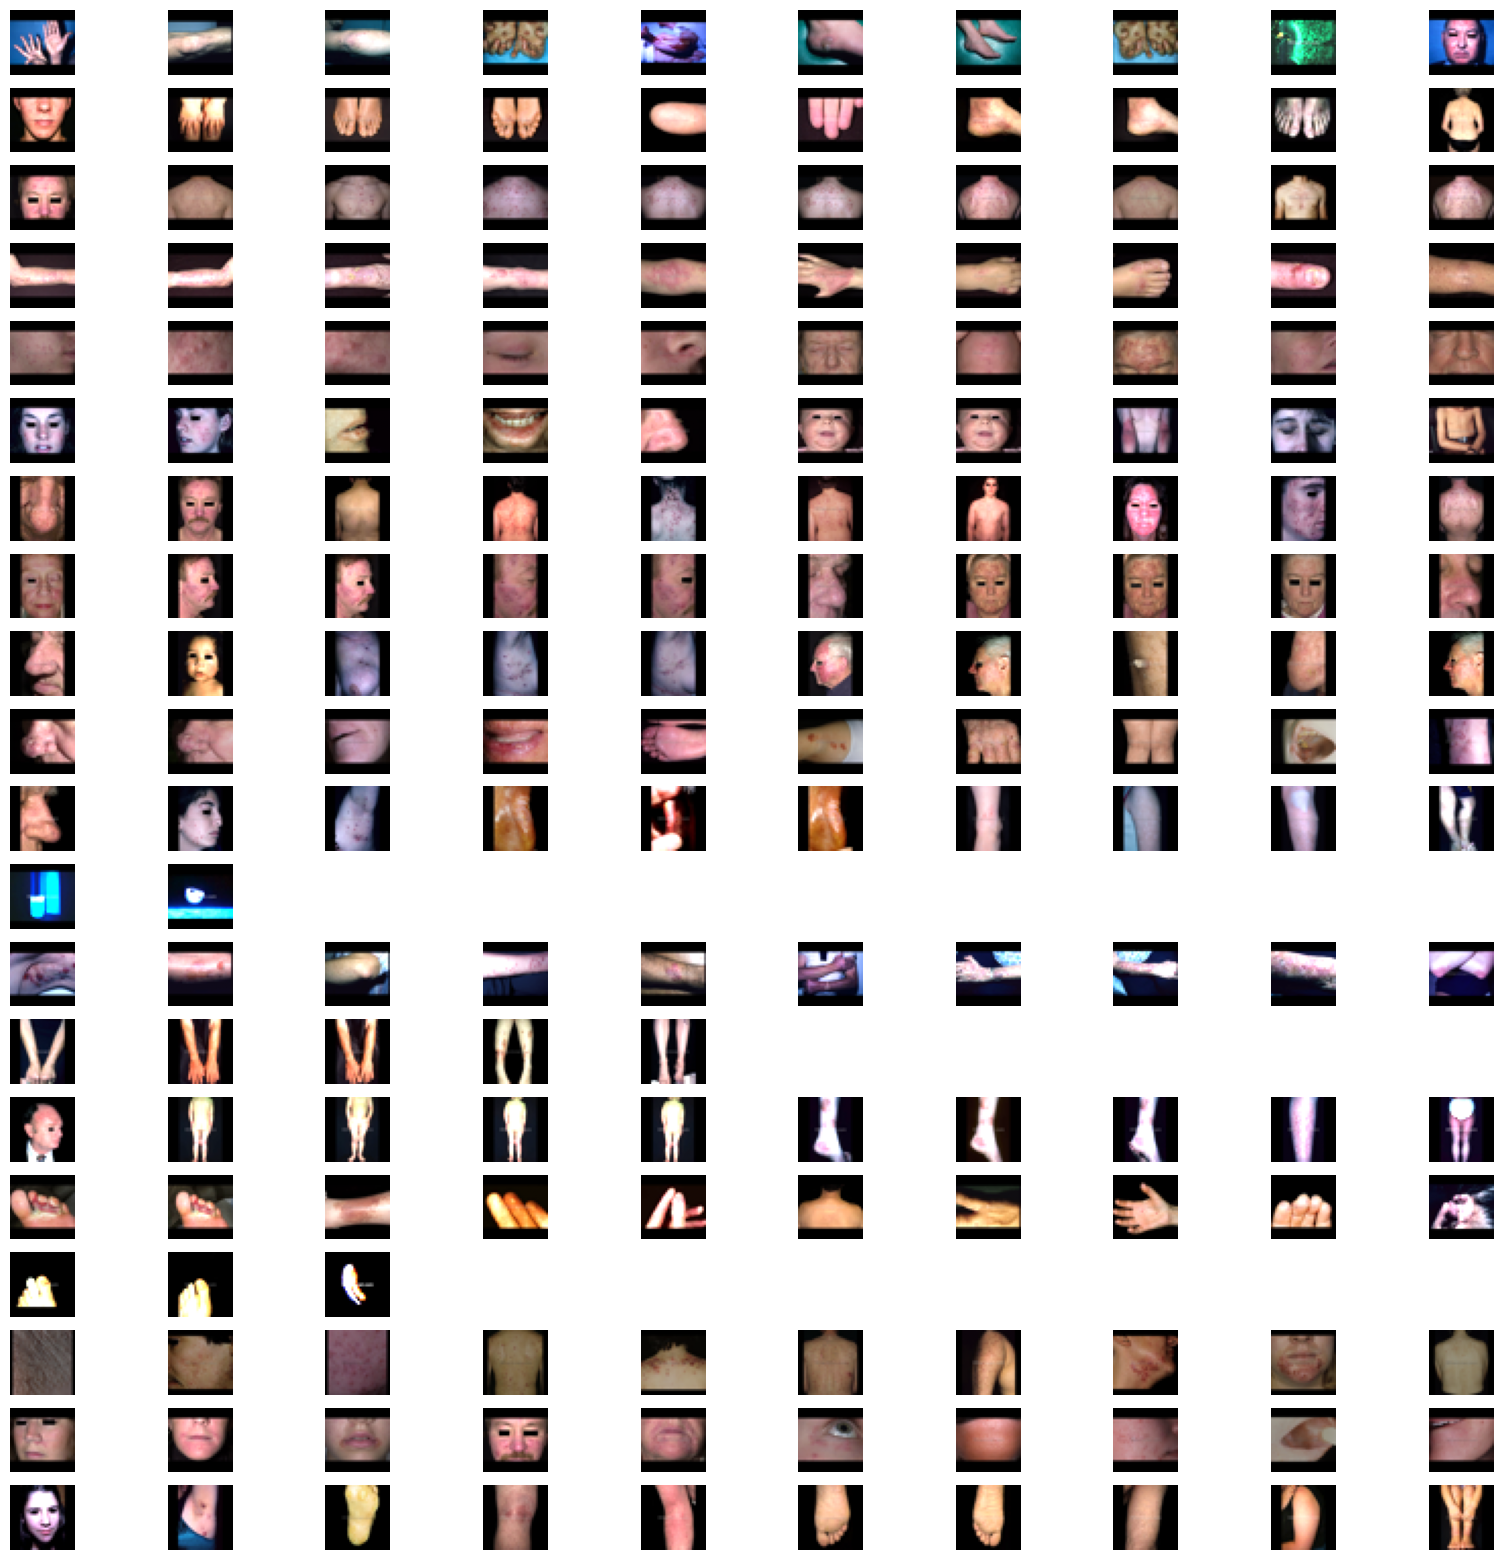

In [26]:
clusters = AgglomerativeClustering(n_clusters=num_clusters, linkage='complete').fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### Agglomerative ward linkage average

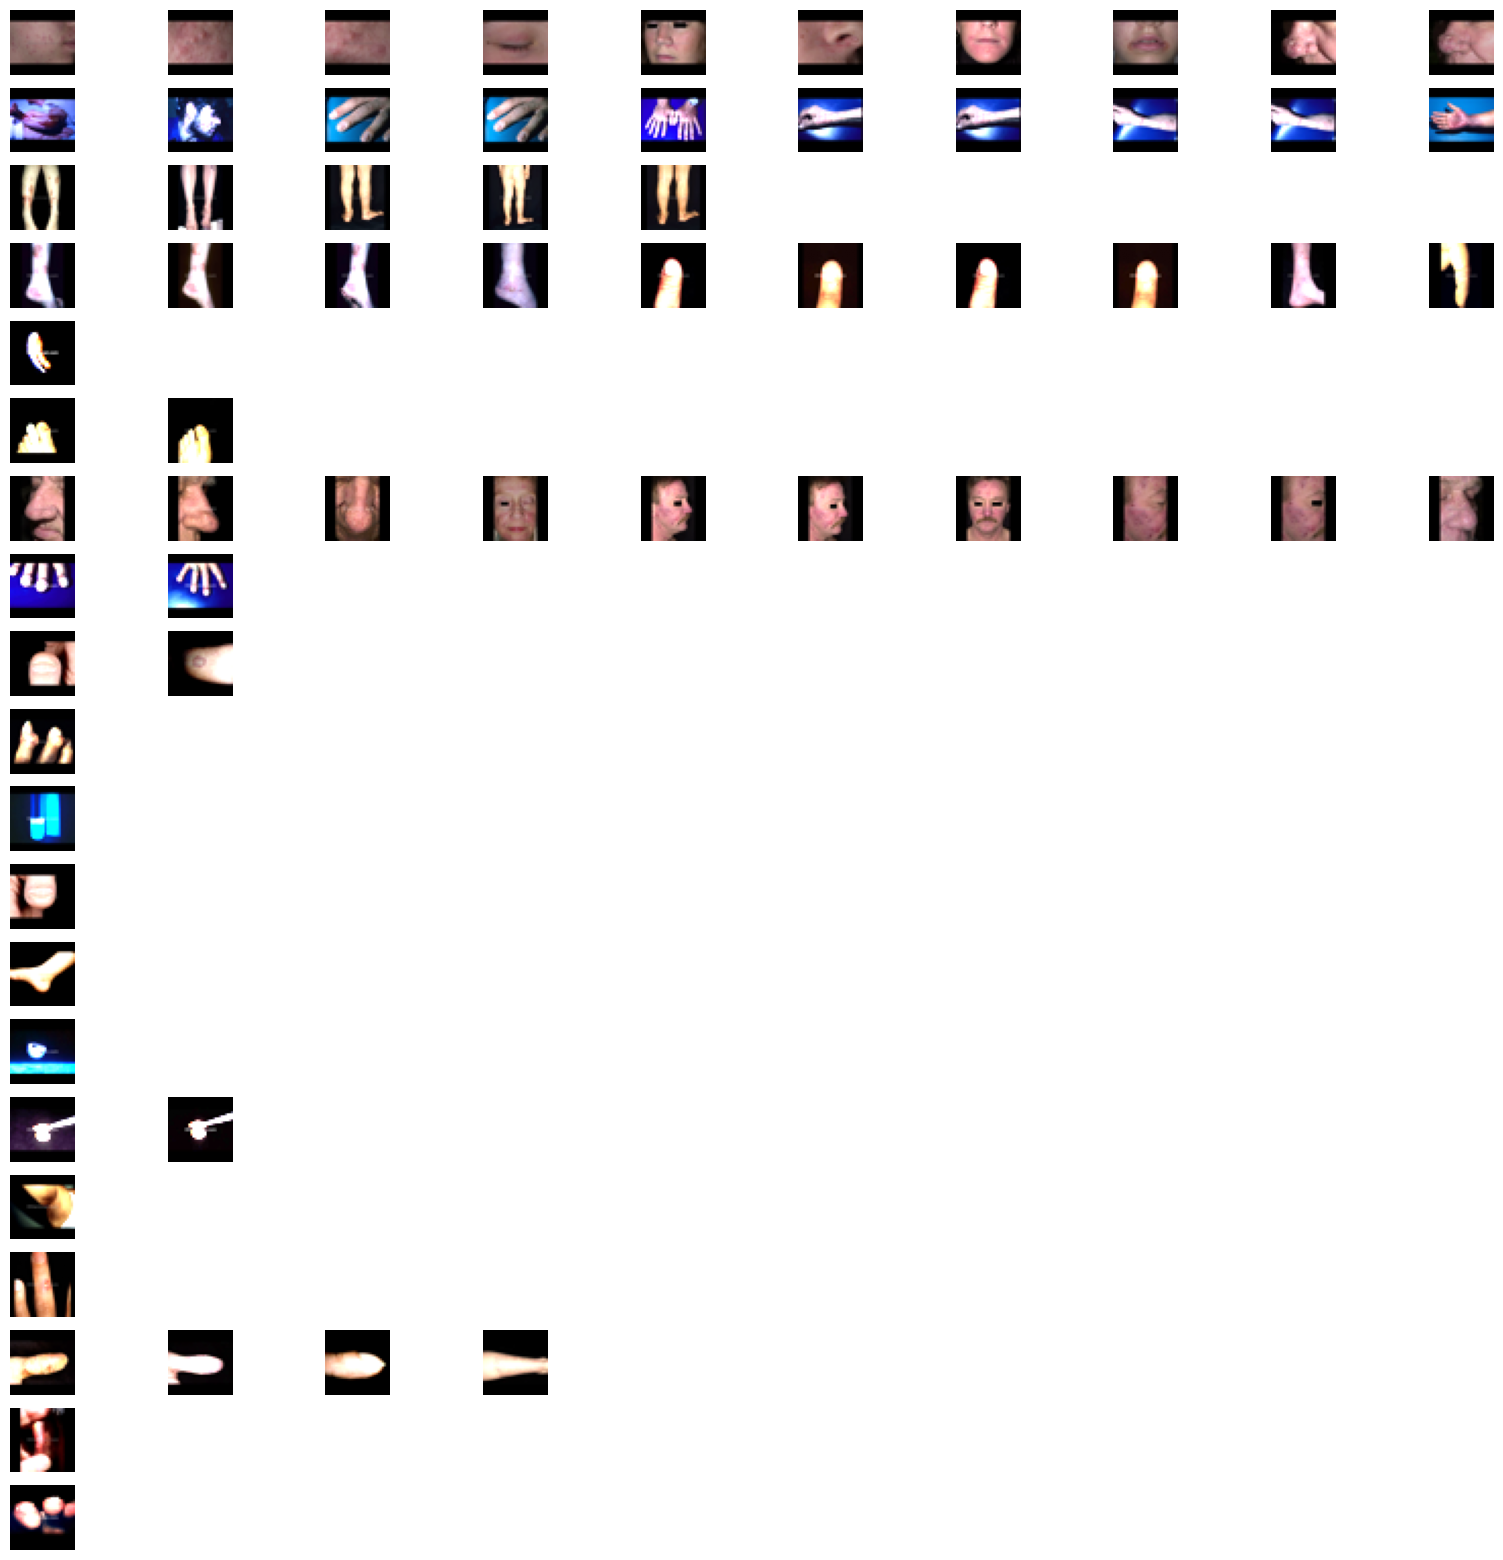

In [27]:
clusters = AgglomerativeClustering(n_clusters=num_clusters, linkage='average').fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### Agglomerative ward linkage single

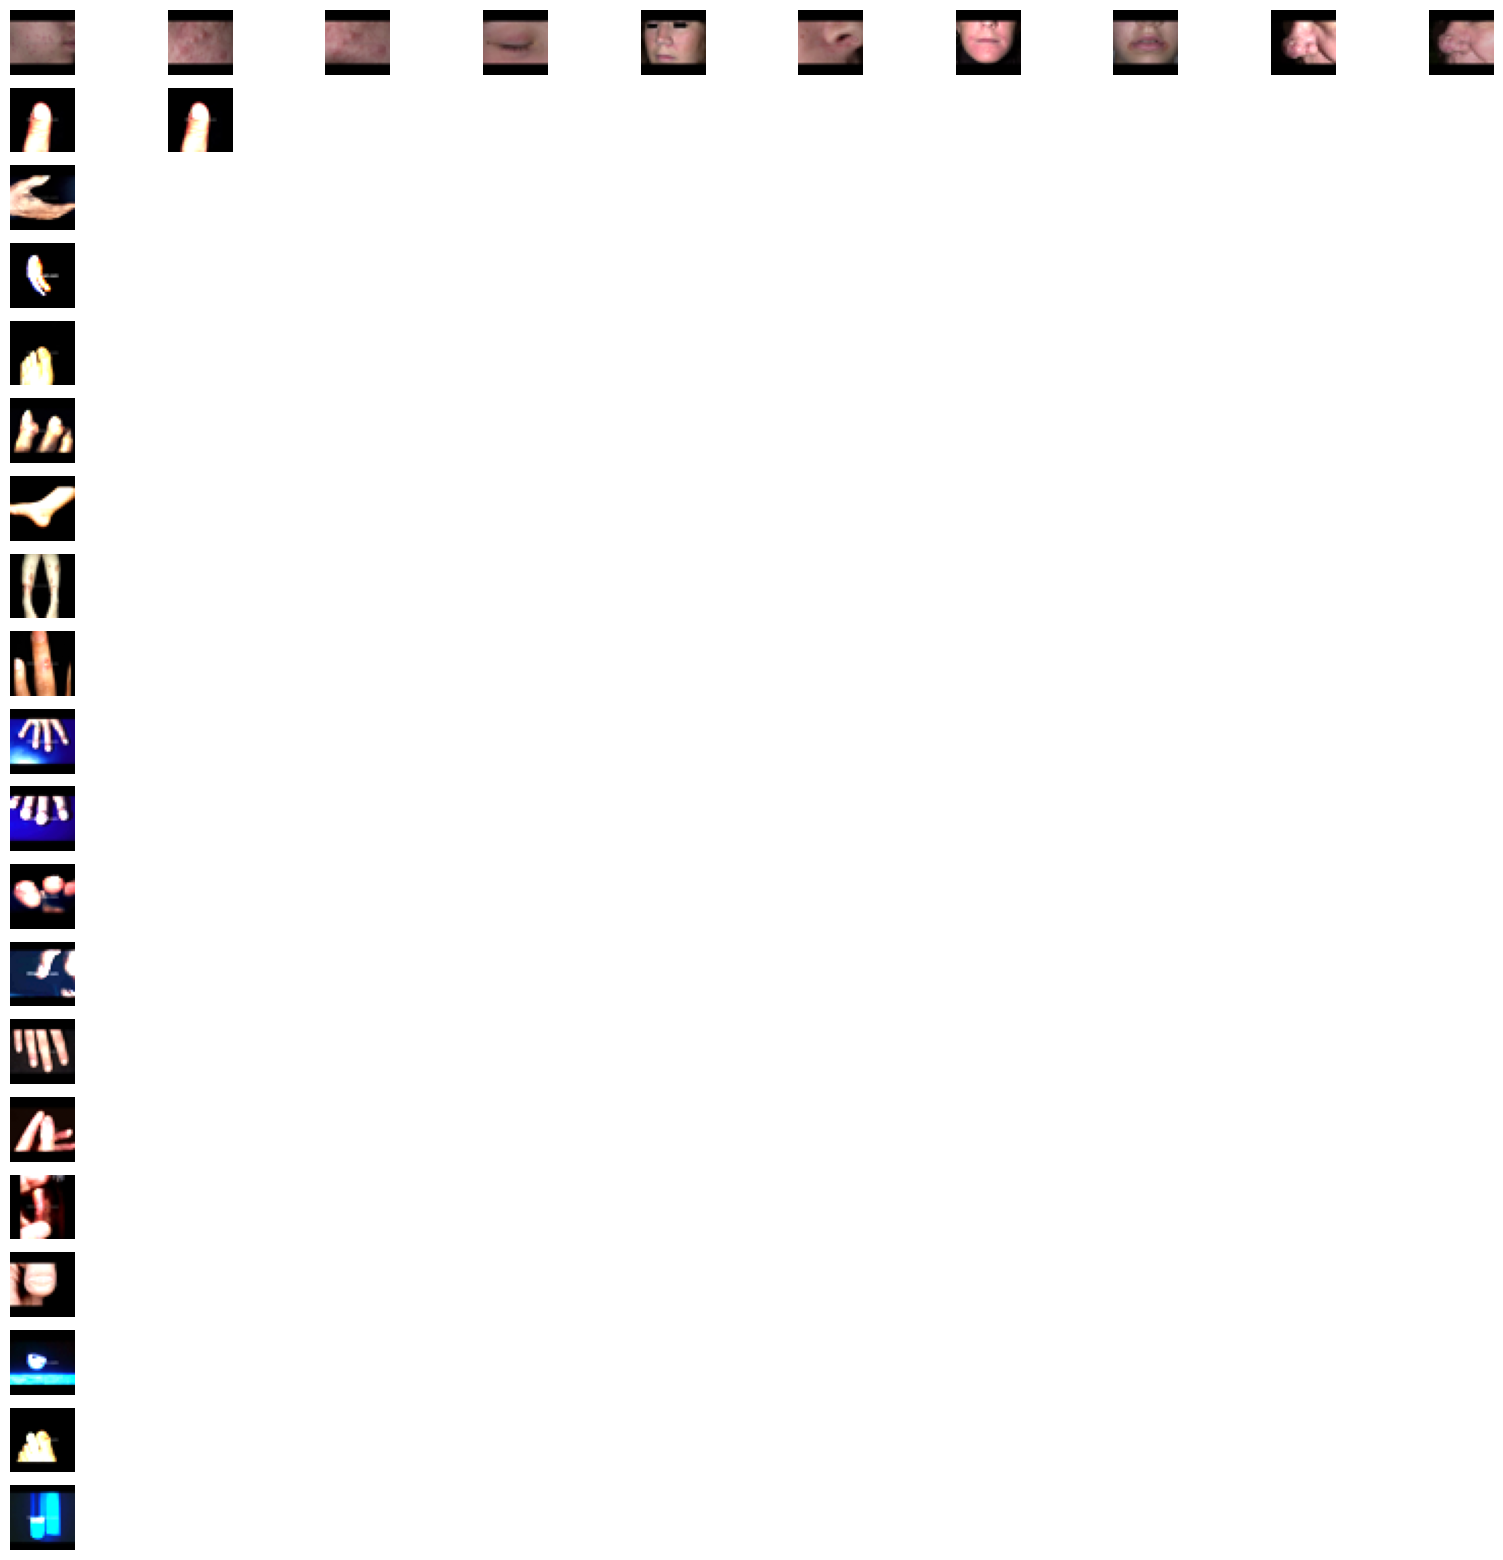

In [28]:
clusters = AgglomerativeClustering(n_clusters=num_clusters, linkage='single').fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### KMeans

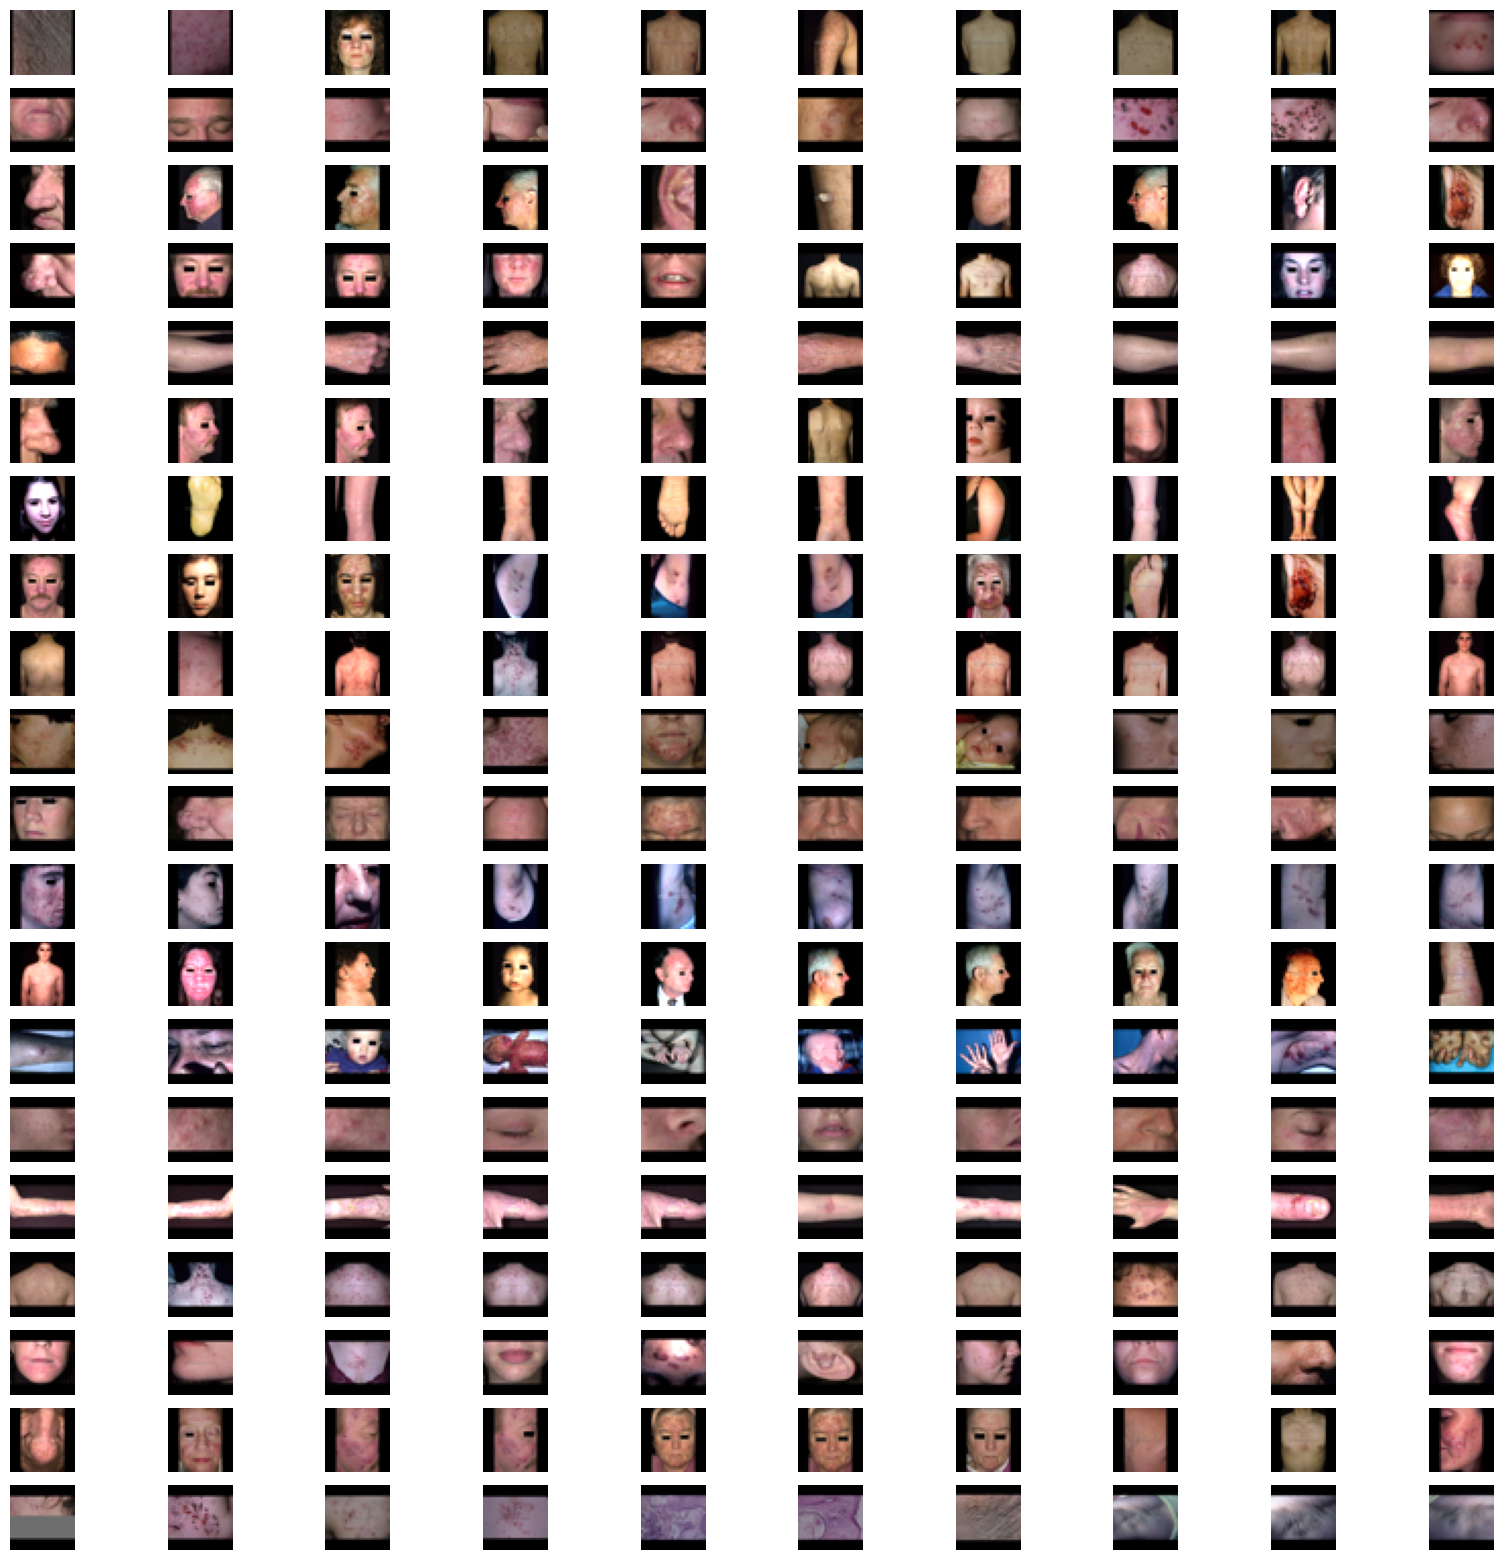

In [29]:
clusters = KMeans(n_clusters=num_clusters, random_state=42).fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

##### KMedoids

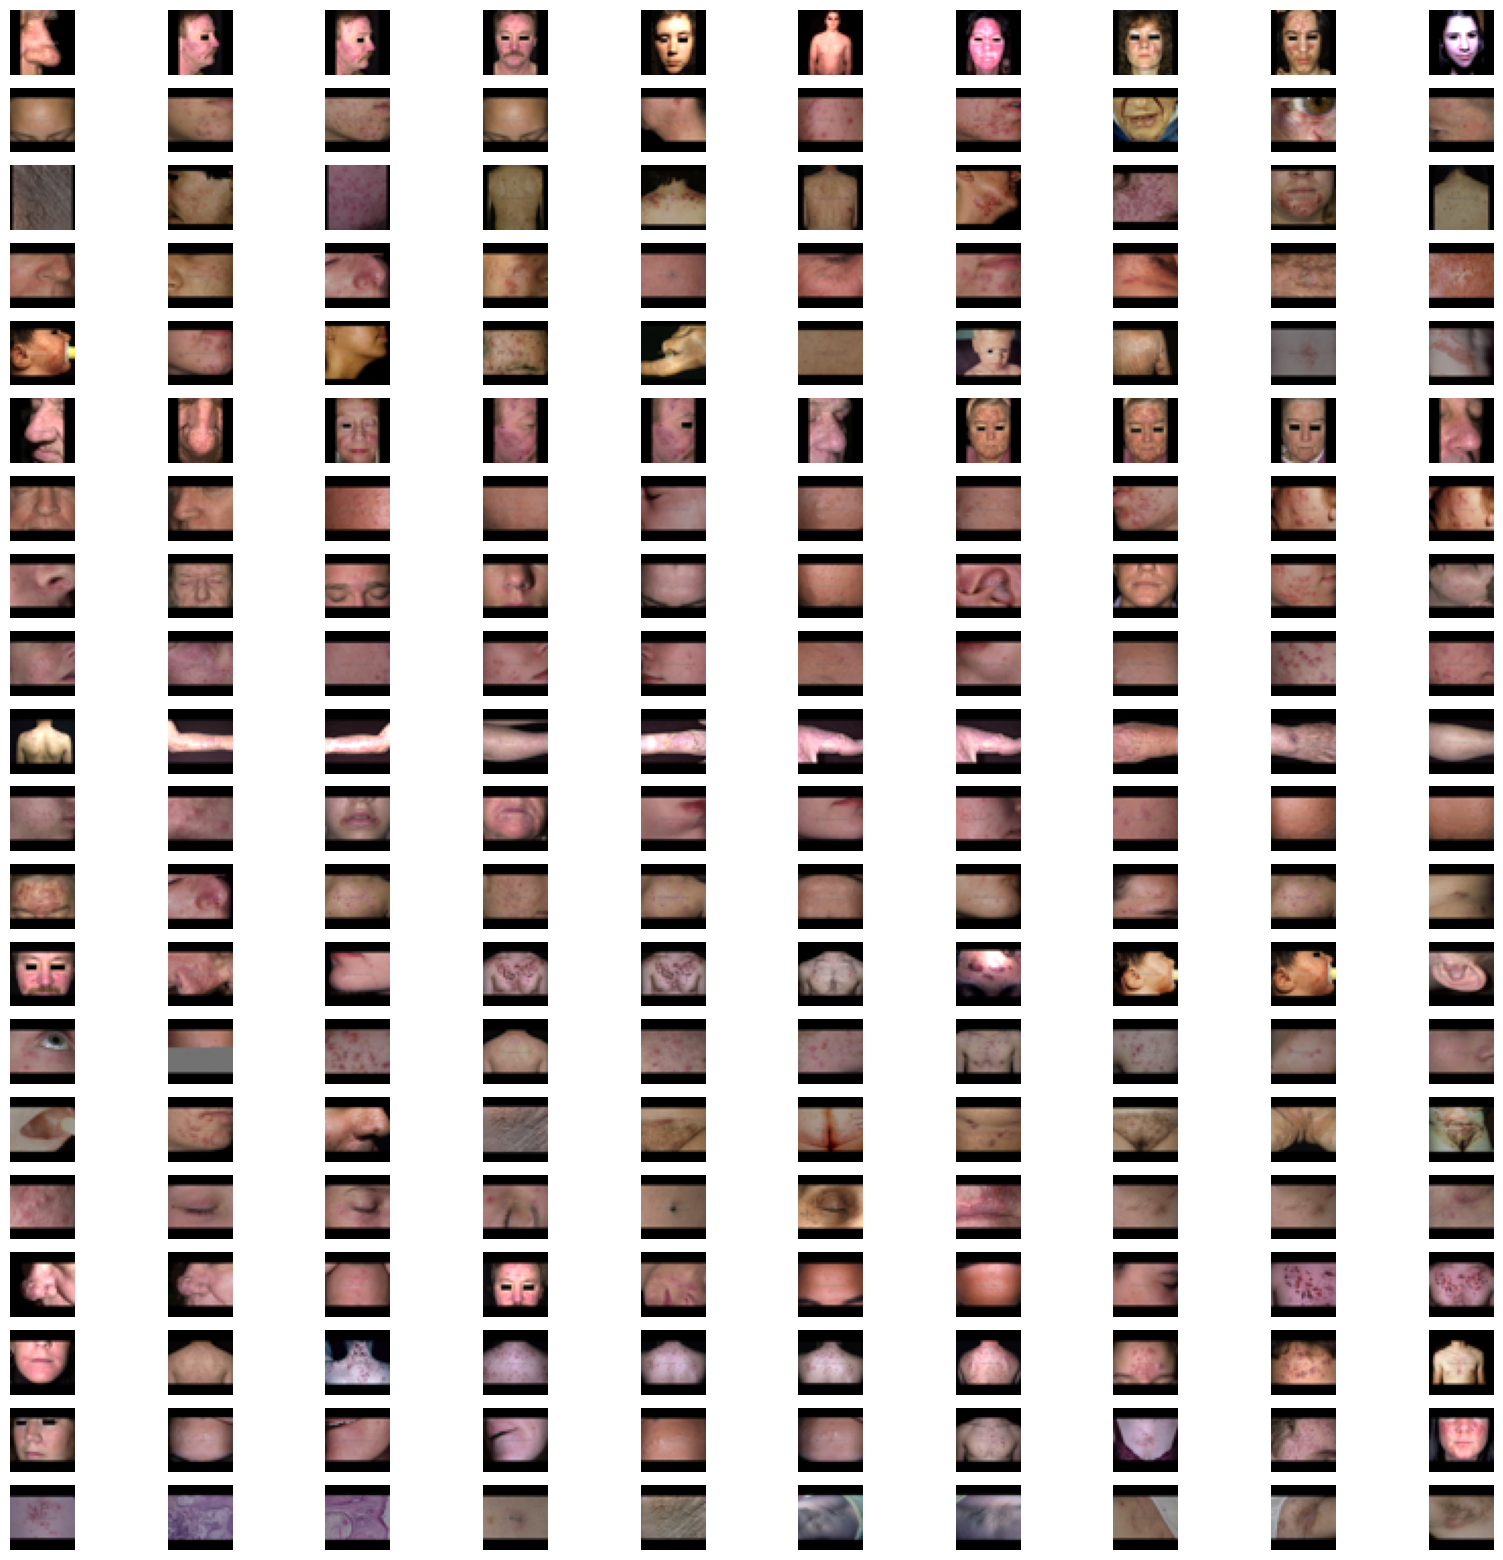

In [30]:
clusters = KMedoids(n_clusters=num_clusters, random_state=42).fit_predict(features)
plot_clusters(images_array, clusters, num_clusters)

###  Further  analysis of Kmeans

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

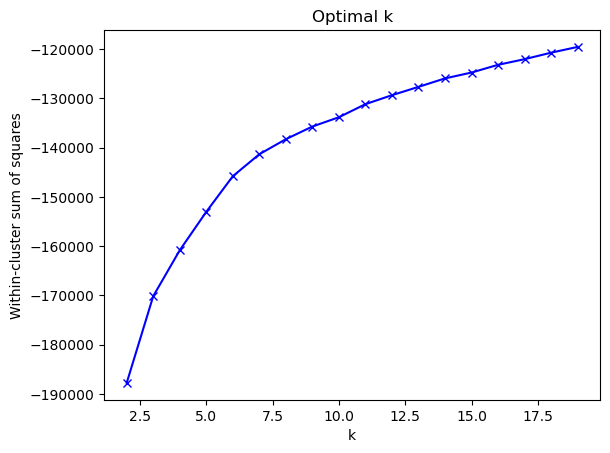

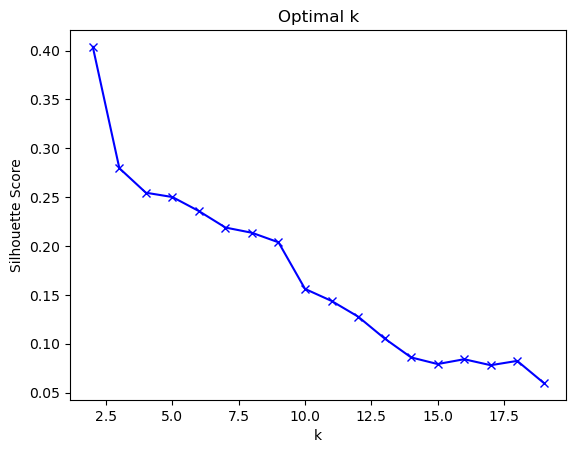

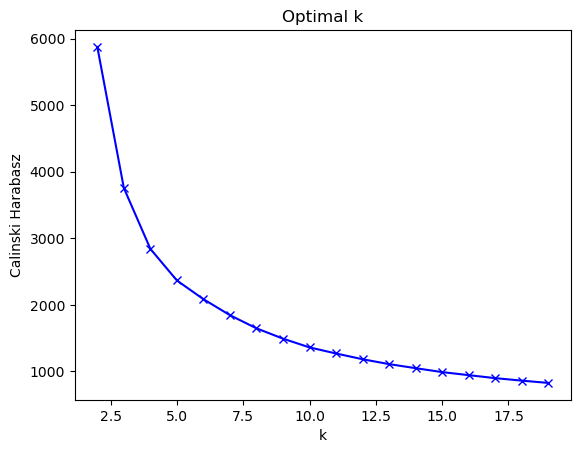

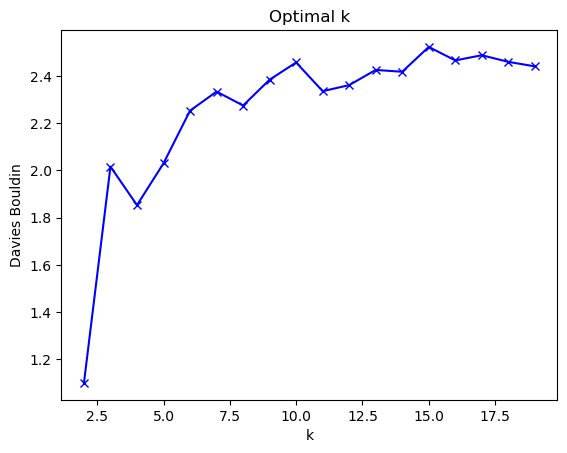

In [146]:
def metrics_plots(max_k, X):

    score = []
    score_kmeans_s = []
    score_kmeans_c = []
    score_kmeans_d = []

    for k in range(2, max_k):
        kmeans = KMeans(n_clusters=k, random_state= 101)
        predictions = kmeans.fit_predict(X)
        # Calculate cluster validation metrics and append to lists of metrics
        score.append(kmeans.score(X))
        score_kmeans_s.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))
        score_kmeans_c.append(calinski_harabasz_score(X, kmeans.labels_))
        score_kmeans_d.append(davies_bouldin_score(X, predictions))
        print(f'{k} ', end='')

    list_scores = [score, score_kmeans_s, score_kmeans_c, score_kmeans_d] 
    # Elbow Method plot
    list_title = ['Within-cluster sum of squares', 'Silhouette Score', 'Calinski Harabasz', 'Davies Bouldin'] 
    for i in range(len(list_scores)):
        x_ticks = list(range(2, len(list_scores[i]) + 2))
        plt.plot(x_ticks, list_scores[i], 'bx-')
        plt.xlabel('k')
        plt.ylabel(list_title[i])
        plt.title('Optimal k')
        plt.show()

features = reduce_dimensions_pca(200, features_original, False)
metrics_plots(20, features)

In [141]:
# Initialize an empty DataFrame
df = pd.DataFrame()
max_parameter = 20

# Example data to add row by row
algorithms = {
    'Kmeans': KMeans
}
metrics = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

index = 0
# Add rows to the DataFrame in a for loop
for p in range(200, 10, -10):
    features = reduce_dimensions_pca(p, features_original, False)
    print('{0: <3}'.format(f'{p}')+' ', end='')
    for i, algorithm in enumerate(algorithms):
        for cluster_num in range(2, max_parameter+1):
            df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
            df.loc[index, 'Feature_len'] = len(features[0])
            df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
            model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
            df.loc[index, 'WCSS'] = count_wcss_scores(features, cluster_num, algorithms[algorithm])
            index += 1
# features = features_original
# for i, algorithm in enumerate(algorithms):
#         print('{0: <33}'.format(f'{algorithm}')+'[-', end='')
#         for cluster_num in range(2, max_parameter+1):
#             print(f'{cluster_num}-', end='')
#             df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
#             df.loc[index, 'Feature_len'] = len(features[0])
#             df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
#             model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
#             df.loc[index, 'WCSS'] = count_wcss_scores(features, cluster_num, algorithms[algorithm])
#             index += 1
#         print(']')
   
df

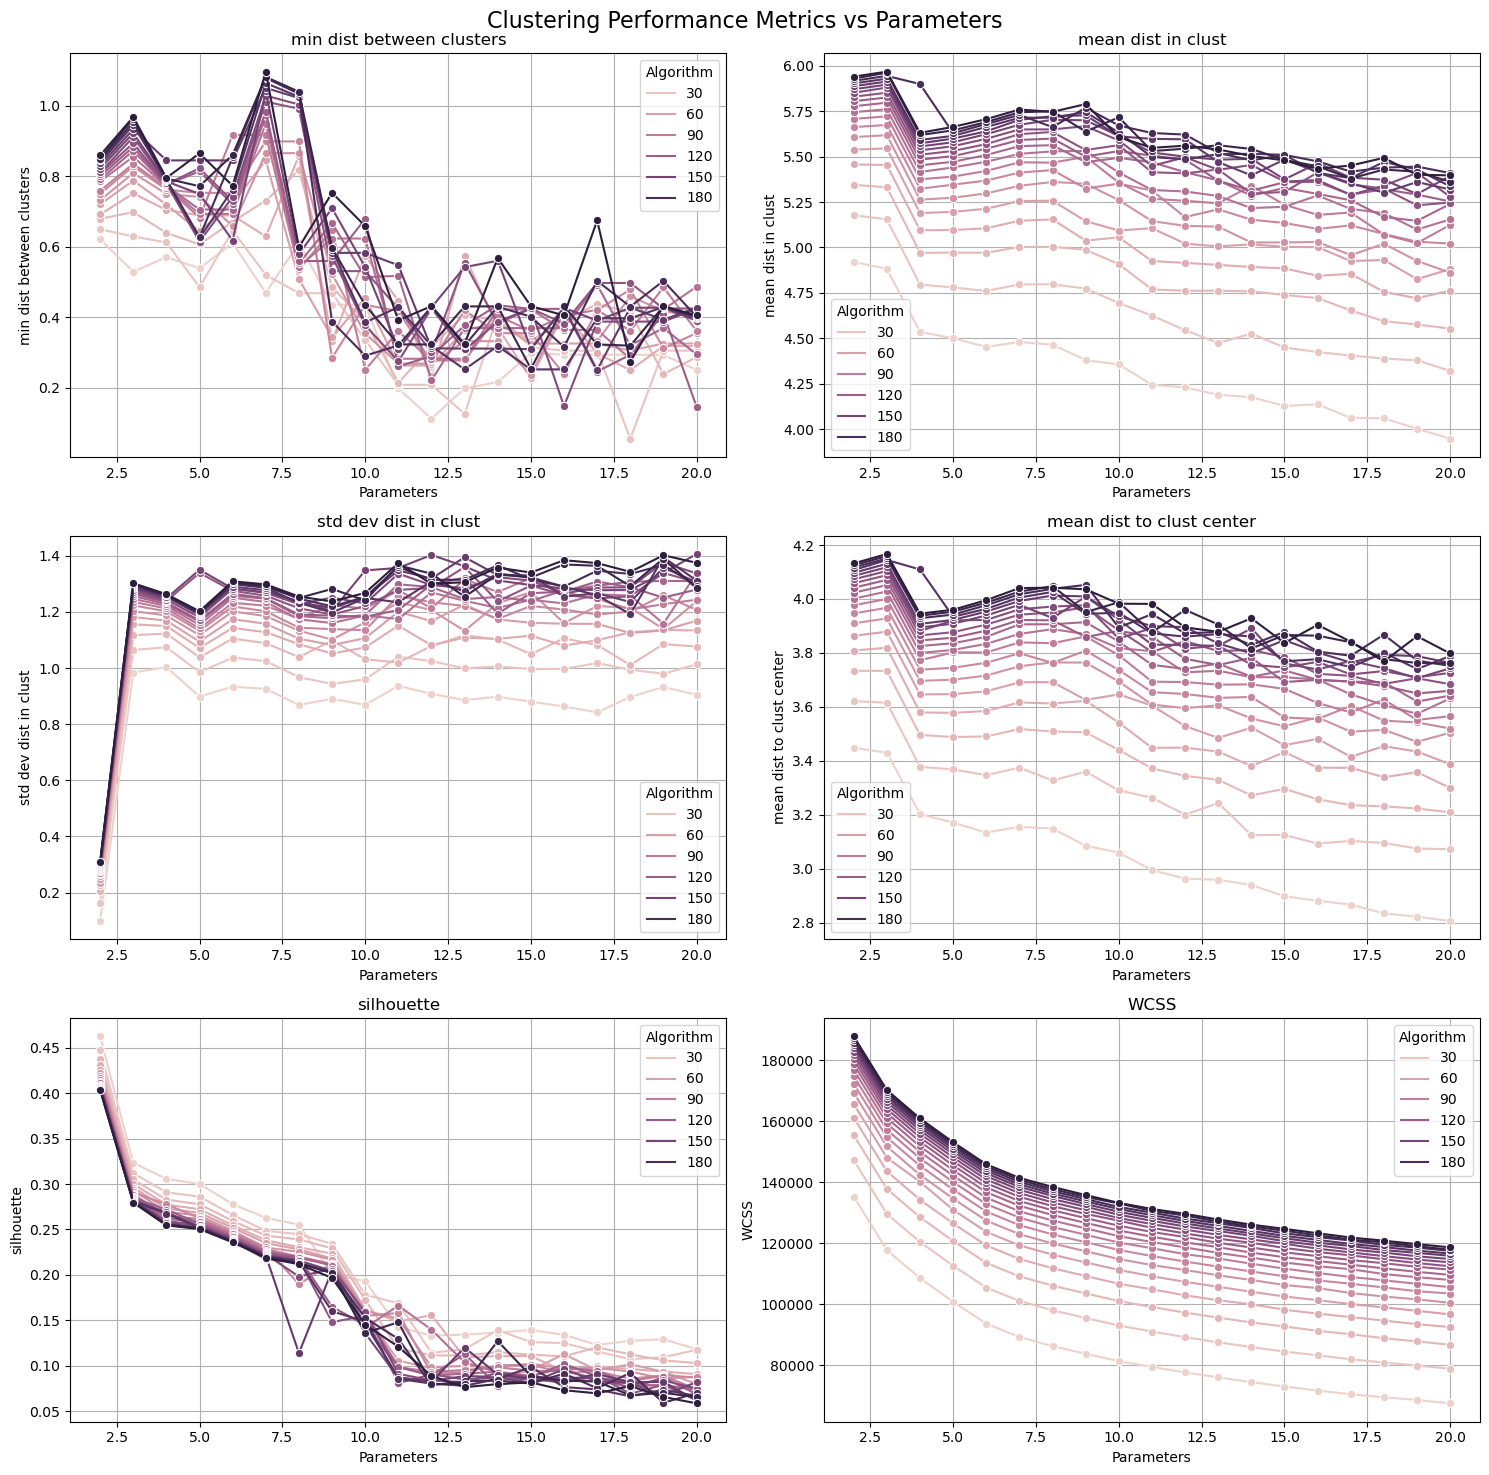

In [144]:
df_tmp = df[df['Feature_len']<1000]

metrics_vals = [
        'min dist between clusters',
        'mean dist in clust',
        'std dev dist in clust',
        'mean dist to clust center',
        'silhouette',
        'WCSS'
]

# Set up the subplot grid (3 rows, 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
axes = axes.flatten()

# Iterate over metrics and create a plot for each
for i, metric in enumerate(metrics_vals):
    sns.lineplot(data=df_tmp, x='Parameters', y=metric, hue='Feature_len', marker='o', ax=axes[i])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Parameters')
    axes[i].legend(title='Algorithm')
    axes[i].grid(True)
fig.suptitle('Clustering Performance Metrics vs Parameters', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show() 

### Kmeans vs KMedoids for 200 feature vector

In [151]:
# Initialize an empty DataFrame
df = pd.DataFrame()
max_parameter = 20

# Example data to add row by row
algorithms = {
    'Kmeans': KMeans,
    'KMedoids': KMedoids
}
metrics = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

index = 0
features = reduce_dimensions_pca(200, features_original, False)
for i, algorithm in enumerate(algorithms):
        print('{0: <33}'.format(f'{algorithm}')+'[-', end='')
        for cluster_num in range(2, max_parameter+1):
            print(f'{cluster_num}-', end='')
            df.loc[index, ['Algorithm', 'Parameters']] = algorithm, cluster_num
            df.loc[index, 'Feature_len'] = len(features[0])
            df.loc[index, metrics.keys()] = [count_clustering_scores(X=features, cluster_num=cluster_num,
            model=algorithms[algorithm], score_fun=metrics[key]) for key in metrics]
            index += 1
        print(']')
   
df

Kmeans                           [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]
KMedoids                         [-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-]


Algorithm  Parameters  Feature_len  min dist between clusters  \
0     Kmeans         2.0        200.0                   0.859890   
1     Kmeans         3.0        200.0                   0.967882   
2     Kmeans         4.0        200.0                   0.793955   
3     Kmeans         5.0        200.0                   0.770811   
4     Kmeans         6.0        200.0                   0.864157   
5     Kmeans         7.0        200.0                   1.106465   
6     Kmeans         8.0        200.0                   1.047859   
7     Kmeans         9.0        200.0                   0.599130   
8     Kmeans        10.0        200.0                   0.564175   
9     Kmeans        11.0        200.0                   0.324529   
10    Kmeans        12.0        200.0                   0.564175   
11    Kmeans        13.0        200.0                   0.324529   
12    Kmeans        14.0        200.0                   0.431177   
13    Kmeans        15.0        200.0                   0.318862   
14    Kmeans        16.0        200.0                   0.431177   
15    Kmeans        17.0        200.0                   0.431177   
16    Kmeans        18.0        200.0                   0.255706   
17    Kmeans        19.0        200.0                   0.405513   
18    Kmeans        20.0        200.0                   0.405513   
19  KMedoids         2.0        200.0                   0.538537   
20  KMedoids         3.0        200.0                   0.324529   
21  KMedoids         4.0        200.0                   0.494811   
22  KMedoids         5.0        200.0                   0.437470   
23  KMedoids         6.0        200.0                   0.266230   
24  KMedoids         7.0        200.0                   0.266230   
25  KMedoids         8.0        200.0                   0.321351   
26  KMedoids         9.0        200.0                   0.268282   
27  KMedoids        10.0        200.0                   0.268282   
28  KMedoids        11.0        200.0                   0.321351   
29  KMedoids        12.0        200.0                   0.321351   
30  KMedoids        13.0        200.0                   0.321351   
31  KMedoids        14.0        200.0                   0.000000   
32  KMedoids        15.0        200.0                   0.321351   
33  KMedoids        16.0        200.0                   0.268282   
34  KMedoids        17.0        200.0                   0.268282   
35  KMedoids        18.0        200.0                   0.321351   
36  KMedoids        19.0        200.0                   0.238553   
37  KMedoids        20.0        200.0                   0.000000   

    mean dist in clust  std dev dist in clust  mean dist to clust center  \
0             5.939713               0.306882                   4.131806   
1             5.968435               1.302148                   4.166811   
2             5.631082               1.156084                   3.945665   
3             5.653189               1.202149                   3.962284   
4             5.706660               1.311493                   3.997285   
5             5.757332               1.296059                   4.035498   
6             5.771076               1.251420                   4.056638   
7             5.783967               1.225113                   4.053744   
8             5.668603               1.281837                   3.996048   
9             5.551730               1.355332                   3.954867   
10            5.542976               1.294874                   3.890218   
11            5.564877               1.315681                   3.885981   
12            5.537627               1.352779                   3.912197   
13            5.546521               1.352636                   3.797640   
14            5.435621               1.304374                   3.843511   
15            5.522789               1.367342                   3.866081   
16            5.445961               1.390449             

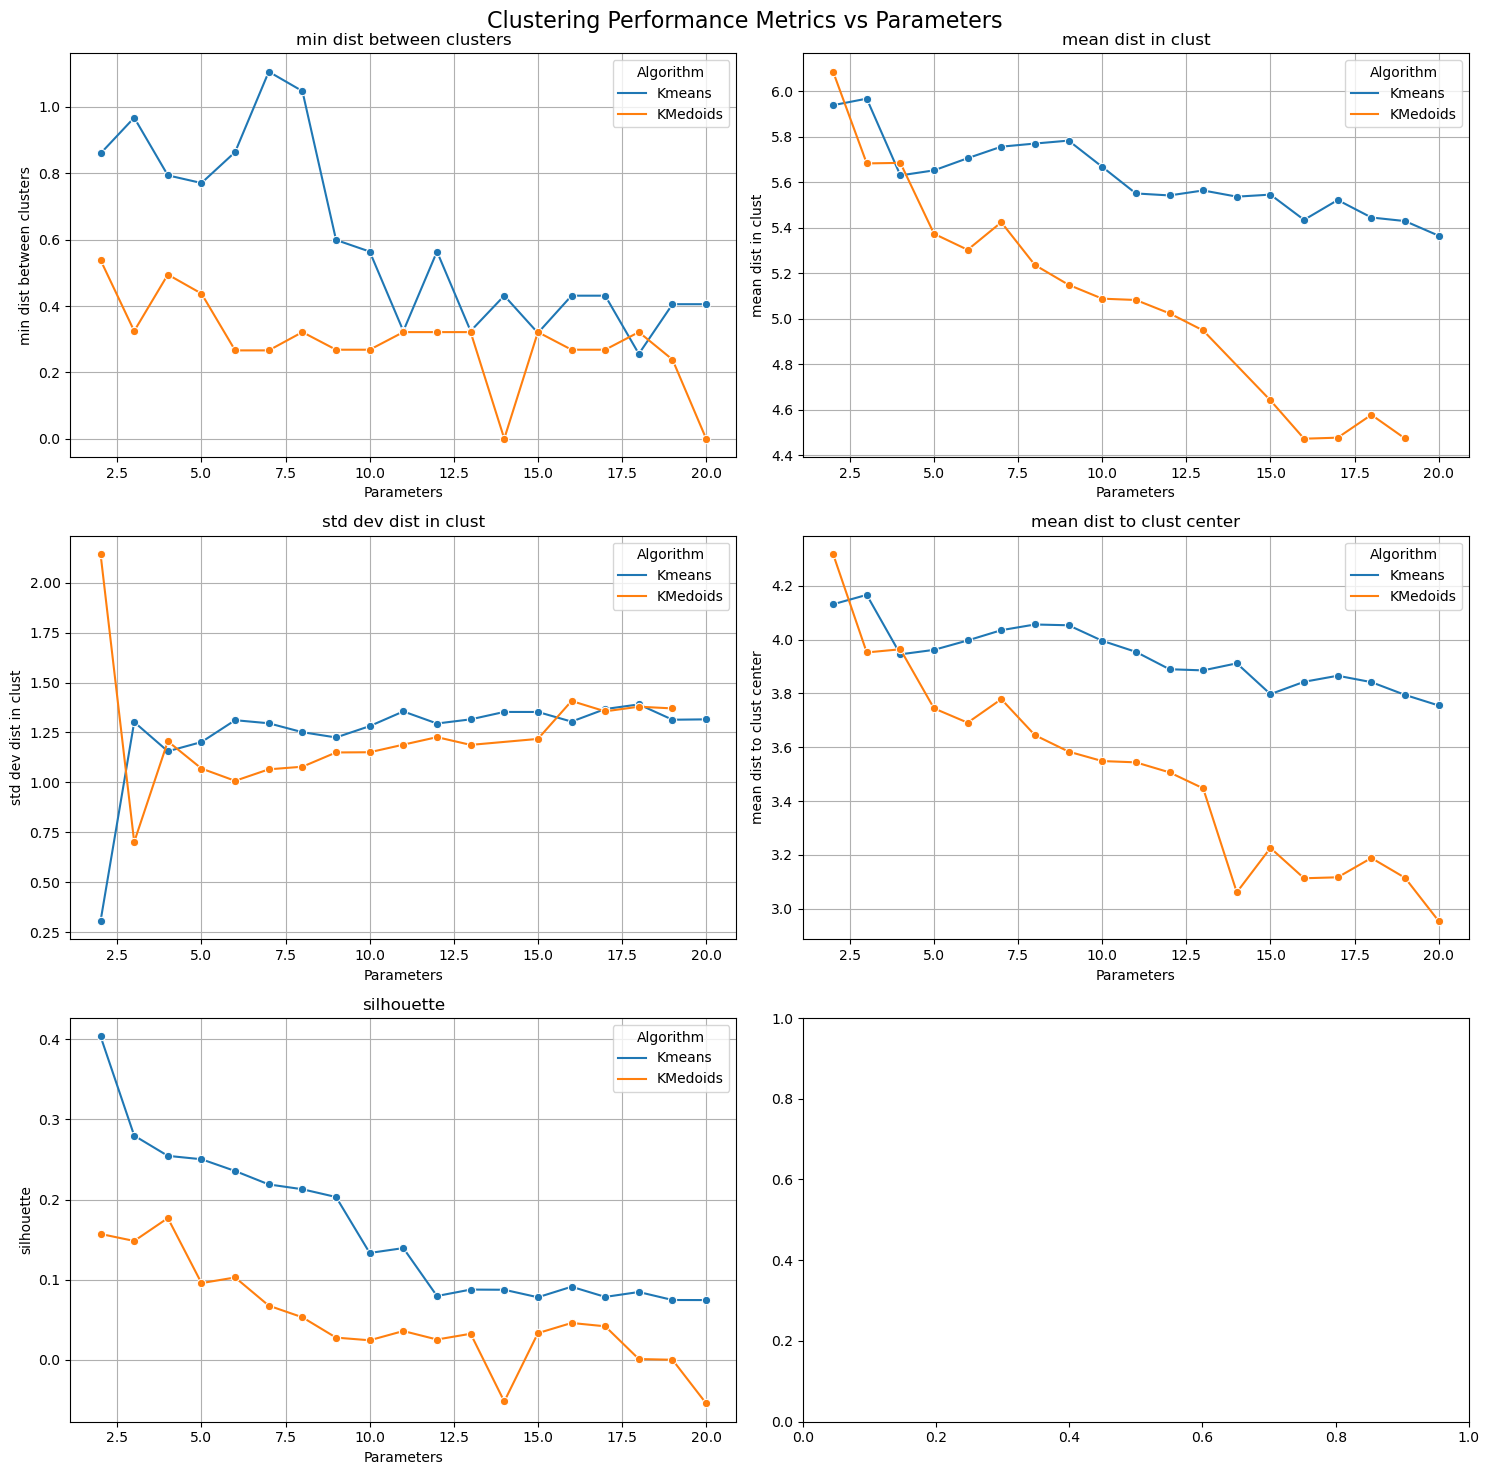

In [155]:
def plot_df(df):
    # List of metrics to plot
    metrics_vals = [
        'min dist between clusters',
        'mean dist in clust',
        'std dev dist in clust',
        'mean dist to clust center',
        'silhouette'
    ]

    # Set up the subplot grid (3 rows, 2 columns)
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    # Iterate over metrics and create a plot for each
    for i, metric in enumerate(metrics_vals):
        sns.lineplot(data=df, x='Parameters', y=metric, hue='Algorithm', marker='o', ax=axes[i])
        axes[i].set_title(f'{metric}')
        axes[i].set_ylabel(metric)
        axes[i].set_xlabel('Parameters')
        axes[i].legend(title='Algorithm')
        axes[i].grid(True)
    fig.suptitle('Clustering Performance Metrics vs Parameters', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
plot_df(df)

## Conclusion
The best performing clustering algorithm for CNN is KMedoids.

The number of clusters and the feature vector lengh that give the best results is indetermined.

It seems as if all metrics have better values with increasing number of features and clusters, but due to limited computational power only a part of passible parameters was checked.

Feature vector was ultimately reduced to a 200 dimansional one with PCA and the number of clusters giving the best results was determined to be >20 in order to minimize the overlap between image groups.